In [1]:
import torch
import numpy as np
from scipy import stats
import matplotlib as mpl
import matplotlib.pyplot as pl
torch.cuda.is_available()
import torchvision
import torchvision.datasets as datasets
import time
import torch.jit as jit
from torch import nn
from torch import optim
from os.path import exists
import params as par
par.N_esn

/home/jb739/apps/anaconda3/envs/venv/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/jb739/apps/anaconda3/envs/venv/lib/python3.8/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: /home/jb739/apps/anaconda3/envs/venv/lib/python3.8/site-packages/torchvision/image.so: undefined symbol: _ZN2at4_ops19empty_memory_format4callEN3c108ArrayRefINS2_6SymIntEEENS2_8optionalINS2_10ScalarTypeEEENS6_INS2_6LayoutEEENS6_INS2_6DeviceEEENS6_IbEENS6_INS2_12MemoryFormatEEE
  warn(f"Failed to load image Python extension: {e}")


1000

In [2]:
mnist_trainset = datasets.MNIST(root='./data', train=True, download=True, transform=None)
mnist_testset = datasets.MNIST(root='./data', train=False, download=True, transform=None)

In [112]:
X_te=mnist_testset.data               ## Test set images
y_te=mnist_testset.test_labels        ## Test set labels

N_o=10                                ## Number of output nodes/classes
N_te=y_te.size()[0]                   ## Number of test samples
Y_te=torch.zeros([N_te,N_o])          ## Initialisation of the one-hot encoded labels for the test set
Y_te[np.arange(0,N_te),y_te]=1        ## From labels to one-hot encoded labels for the test set

X_tr=mnist_trainset.data              ## Train set images
y_tr=mnist_trainset.train_labels      ## Train labels 
N_tr=y_tr.size()[0]                   ## Number of training samples
N_i = X_tr.size()[1]                  ## Number of inputs to ESN

Y_tr=torch.zeros([N_tr,N_o])          ## Initialisation of one-hot encoded labels for training
Y_tr[np.arange(0,N_tr),y_tr]=1        ## From labels to one-hot encoded labels for the training set

N_val=10000                           ## Here I take out N_val samples from the training set and use them for validation
i_val=np.random.permutation(np.arange(0,N_tr))[0:N_val]

X_val=X_tr[i_val,:,:]
Y_val=Y_tr[i_val,:]

i_tr=np.delete(np.arange(0,N_tr),i_val)
N_tr=N_tr-N_val

X_tr=X_tr[i_tr,:,:]
Y_tr=Y_tr[i_tr,:]

T=X_tr.size()[2]
N_in=X_tr.size()[1]

## Normalisation and conversion to float
X_M=255
# X_tr=torch.reshape( (X_tr.float()/X_M),[-1,784]) 
# X_val=torch.reshape((X_val.float()/X_M),[-1,784])
# X_te=torch.reshape((X_te.float()/X_M),[-1,784])
X_tr=torch.reshape( (X_tr.float()),[-1,784]) 
X_val=torch.reshape((X_val.float()),[-1,784])
X_te=torch.reshape((X_te.float()),[-1,784])

for j in range(X_tr.shape[0]):
    X_tr[j,:] -= torch.mean(X_tr[j,:])
    X_tr[j,:] /= torch.std(X_tr[j,:])

for j in range(X_val.shape[0]):
    X_val[j,:] -= torch.mean(X_val[j,:])
    X_val[j,:] /= torch.std(X_val[j,:])

for j in range(X_te.shape[0]):
    X_te[j,:] -= torch.mean(X_te[j,:])
    X_te[j,:] /= torch.std(X_te[j,:])

X_tr=torch.reshape( (X_tr),[-1,28,28]) 
X_val=torch.reshape((X_val),[-1,28,28])
X_te=torch.reshape((X_te),[-1,28,28])

Y_tr=Y_tr.float()
Y_val=Y_val.float()
Y_te=Y_te.float()

print(f'X_tr shape = {X_tr.shape},    Y_tr shape = {Y_tr.shape}')


/home/jb739/apps/anaconda3/envs/venv/lib/python3.8/site-packages/torchvision/datasets/mnist.py:70: UserWarning: test_labels has been renamed targets
  warnings.warn("test_labels has been renamed targets")
/home/jb739/apps/anaconda3/envs/venv/lib/python3.8/site-packages/torchvision/datasets/mnist.py:65: UserWarning: train_labels has been renamed targets
  warnings.warn("train_labels has been renamed targets")


X_tr shape = torch.Size([50000, 28, 28]),    Y_tr shape = torch.Size([50000, 10])


In [132]:
# Add random contrast transformations to input data (OLD VERSION - results in outlines)
for j in range(X_tr.shape[0]):
    X_tr[j,X_tr[j,:]==X_tr[j,:].min()] = X_tr[j,X_tr[j,:]==X_tr[j,:].min()] + torch.rand(1) * torch.tensor(2.) * (X_tr[j,:].max() - X_tr[j,:].min())
for j in range(X_val.shape[0]):
    X_val[j,X_val[j,:]==X_val[j,:].min()] = X_val[j,X_val[j,:]==X_val[j,:].min()] + torch.rand(1) * torch.tensor(2.) * (X_val[j,:].max() - X_val[j,:].min())
for j in range(X_te.shape[0]):
    X_te[j,X_te[j,:]==X_te[j,:].min()] = X_te[j,X_te[j,:]==X_te[j,:].min()] + torch.rand(1) * torch.tensor(2.) * (X_te[j,:].max() - X_te[j,:].min())

# Z-score inputs
for j in range(X_tr.shape[0]):
    X_tr[j,:] -= torch.mean(X_tr[j,:])
    X_tr[j,:] /= torch.std(X_tr[j,:])

for j in range(X_val.shape[0]):
    X_val[j,:] -= torch.mean(X_val[j,:])
    X_val[j,:] /= torch.std(X_val[j,:])

for j in range(X_te.shape[0]):
    X_te[j,:] -= torch.mean(X_te[j,:])
    X_te[j,:] /= torch.std(X_te[j,:])

In [113]:
# Add random contrast transformations to input data

# Training data
for j in range(X_tr.shape[0]):
    # Rescale values to range 0-1
    X_tr[j,:] -= torch.min(X_tr[j,:])
    X_tr[j,:] /= torch.max(X_tr[j,:])
    # Reverse contrast with prob. = 0.5
    if torch.rand(1)>0.5:
        X_tr[j,:] = 1. - X_tr[j,:]
    # Z-score
    X_tr[j,:] -= torch.mean(X_tr[j,:])
    X_tr[j,:] /= (torch.std(X_tr[j,:]) / torch.rand(1))

# Validation data
for j in range(X_val.shape[0]):
    # Rescale values to range 0-1
    X_val[j,:] -= torch.min(X_val[j,:])
    X_val[j,:] /= torch.max(X_val[j,:])
    # Reverse contrast with prob. = 0.5
    if torch.rand(1)>0.5:
        X_val[j,:] = 1. - X_val[j,:]
    # Z-score
    X_val[j,:] -= torch.mean(X_val[j,:])
    X_val[j,:] /= (torch.std(X_val[j,:]) / torch.rand(1)) 

# Test data
for j in range(X_te.shape[0]):
    # Rescale values to range 0-1
    X_te[j,:] -= torch.min(X_te[j,:])
    X_te[j,:] /= torch.max(X_te[j,:])
    # Reverse contrast with prob. = 0.5
    if torch.rand(1)>0.5:
        X_te[j,:] = 1. - X_te[j,:]
    # Z-score
    X_te[j,:] -= torch.mean(X_te[j,:])
    X_te[j,:] /= (torch.std(X_te[j,:]) / torch.rand(1))

(tensor(1.0337), tensor(-2.2342))

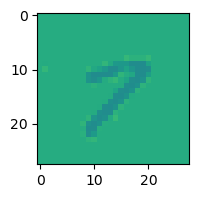

In [135]:
fig = pl.figure(figsize=tuple(np.array((5.,5.))/2.54)); ax = pl.axes()
# for j in range(5):
j = 23
imdata = ax.imshow(np.squeeze(X_tr[j,:,:]),vmin=-11., vmax=7.)
(torch.max(X_tr[j,:]), torch.min(X_tr[j,:]))
    # fig.savefig('/home/jb739/sheffield/proj/esn2sparse/data/mnist_contrast'+str(j)+'.eps', format="eps")
# h=torch.histogram(X_tr[4,:,:], bins=20, range=(-11.,7.))[0] / 784.

In [5]:
class ESN(nn.Module):

    def __init__(self, N, N_i, N_av, alpha, rho, gamma):
        super().__init__()

        self.N = N
        self.alpha = alpha
        self.rho = rho
        self.N_av = N_av
        self.N_i = N_i
        self.gamma = gamma

        dilution = 1-N_av/N
        W = np.random.uniform(-1, 1, [N, N])
        W = W*(np.random.uniform(0, 1, [N, N]) > dilution)
        eig = np.linalg.eigvals(W)
        self.W = torch.from_numpy(
            self.rho*W/(np.max(np.absolute(eig)))).float()

        self.x = []

        if self.N_i == 1:

            self.W_in = 2*np.random.randint(0, 2, [self.N_i, self.N])-1
            self.W_in = torch.from_numpy(self.W_in*self.gamma).float()

        else:

            self.W_in = np.random.randn(self.N_i, self.N)
            self.W_in = torch.from_numpy(self.gamma*self.W_in).float()

    def Reset(self, s):

        batch_size = np.shape(s)[0]
        self.x = torch.zeros([batch_size, self.N])

    def ESN_1step(self, s):

        self.x = (1-self.alpha)*self.x+self.alpha * \
            torch.tanh(torch.matmul(s, self.W_in)+torch.matmul(self.x, self.W))

    def ESN_response(self, Input):

        T = Input.shape[2]
        X = torch.zeros(Input.shape[0], self.N, T)

        self.Reset(Input[:, 0])

        batch = np.max([Input.size()[0], 10000])
        N_b = np.int_(np.ceil(Input.size()[0]/batch))

        for n in range(N_b):

            for t in range(T):

                if n == N_b-1:
                    self.ESN_1step(Input[n*batch:, :, t])
                    X[n*batch:, :, t] = torch.clone(self.x)

                else:
                    self.ESN_1step(Input[n*batch:(n+1)*batch, :, t])
                    X[n*batch:(n+1)*batch, :, t] = torch.clone(self.x)

        return X

    def ESN_crop(self, input, cropsize, cropstop, esn_tau):
        f = np.tile(np.array([[np.exp(-np.arange((cropsize-1),-1,-1)/esn_tau)]]),[input.shape[0],input.shape[1],1])
        output = torch.from_numpy(np.multiply(input[:,:,cropstop-cropsize:cropstop].numpy(), f)).float()
        return output
    
    def ESN_normalise(self, input):
        x = stats.zscore(input.numpy().reshape(input.shape[0], input.shape[1]*input.shape[2]), axis=1)
        output = torch.from_numpy(x).float()
        return output
    
    
# Generate or load ESN data
inputDir = './data/'    # Storage directory for input/label data
esnname_tr = inputDir + 'esn_train.pt'
esnname_val = inputDir + 'esn_validate.pt'
esnname_te = inputDir + 'esn_test.pt'
if exists(esnname_tr):
    X_tr = torch.load(esnname_tr)
    X_val = torch.load(esnname_val)
    X_te = torch.load(esnname_te)
else:
    # Initialise ESN
    esn = ESN(par.N_esn, N_i, par.N_av, par.alpha, par.rho, par.gamma)
    # Compute ESN responses
    cropargs = np.array([28,28]) # [cropsize, cropstop]
    crop_tau = np.inf
    esn_tr = esn.ESN_response(X_tr) # Training data
    esn_tr = esn.ESN_crop(esn_tr, cropargs[0], cropargs[1], crop_tau) # Crop data in time
    X_tr = esn.ESN_normalise(esn_tr)  # z-score each sample
    esn_val = esn.ESN_response(X_val) # Validation data
    esn_val = esn.ESN_crop(esn_val, cropargs[0], cropargs[1], crop_tau) # Crop data in time
    X_val = esn.ESN_normalise(esn_val)  # z-score each sample
    esn_te = esn.ESN_response(X_te) # Test data
    esn_te = esn.ESN_crop(esn_te, cropargs[0], cropargs[1], crop_tau) # Crop data in time
    X_te = esn.ESN_normalise(esn_te)  # z-score each sample

print(f'X_tr shape = {X_tr.shape},    Y_tr shape = {Y_tr.shape}')
# X_tr = tr#torch.tensor(stats.zscore(tr[:,27::28].numpy(), axis=1))
# X_val = val#torch.tensor(stats.zscore(val[:,27::28].numpy(), axis=1))
# X_te = te#torch.tensor(stats.zscore(te[:,27::28].numpy(), axis=1))

X_tr shape = torch.Size([50000, 28000]),    Y_tr shape = torch.Size([50000, 10])


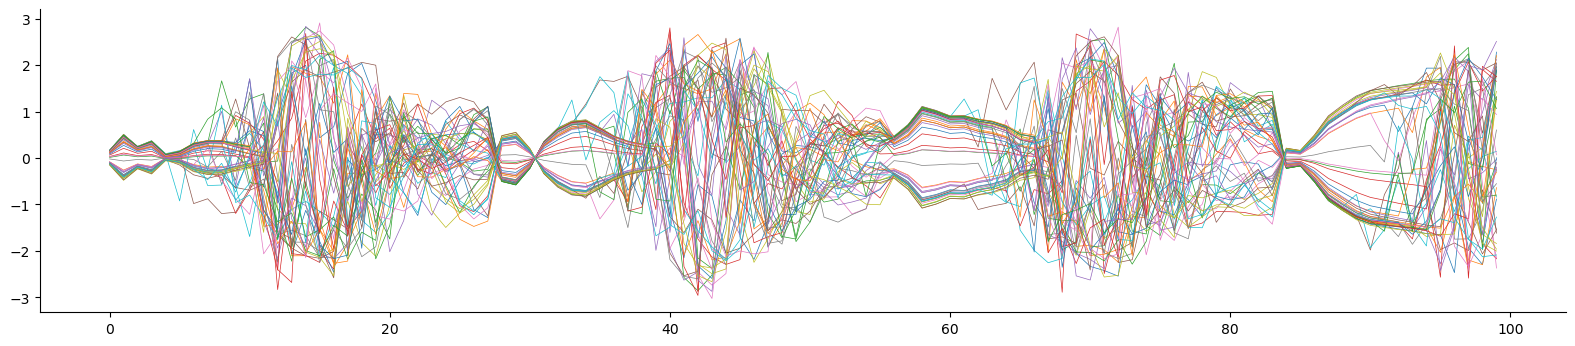

In [8]:
fig = pl.figure(figsize=tuple(np.array((50.,10.))/2.54)); ax = pl.axes()
ax.spines[['top','right']].set_visible(False)
pl.plot(torch.transpose(X_tr[1][0:50,0:100],0,1), linewidth=0.5)

In [239]:
# IF NOT USING ESN
# Make inputs 2800-dim and z-score
from scipy import stats
with torch.no_grad():
    w = torch.randn([784, 2800])/torch.sqrt(torch.tensor(2800+784))
    X_tr = torch.tensor(stats.zscore(torch.matmul(X_tr.reshape(X_tr.shape[0], X_tr.shape[1]*X_tr.shape[2]), w).numpy(), axis=1))
    X_val = torch.tensor(stats.zscore(torch.matmul(X_val.reshape(X_val.shape[0], X_val.shape[1]*X_val.shape[2]), w).numpy(), axis=1))
    X_te = torch.tensor(stats.zscore(torch.matmul(X_te.reshape(X_te.shape[0], X_te.shape[1]*X_te.shape[2]), w).numpy(), axis=1))



In [7]:
def Data2Classes(X,Y):
    
    ind=torch.where(Y==1)[1]

    N_class=torch.max(ind)+1
    
    X1=[]
    Y1=[]
    
    for n in range(N_class):
    
        ind1=torch.where(ind==n)[0].type(torch.long)

        X1.append(X[ind1,:])
        Y1.append(Y[ind1,:])
        
    return X1, Y1
        
# X_tr/X_val/X_te are lists of length 10 (1 entry per class)
X_tr, Y_tr=Data2Classes(X_tr,Y_tr)

X_val, Y_val=Data2Classes(X_val,Y_val)

X_te, Y_te=Data2Classes(X_te,Y_te)

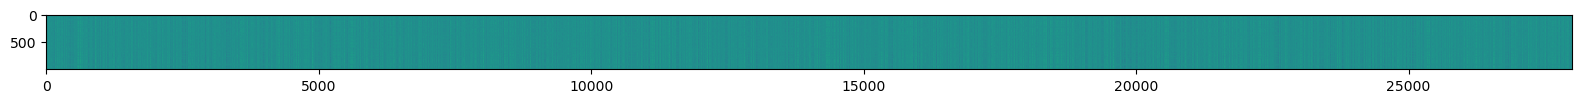

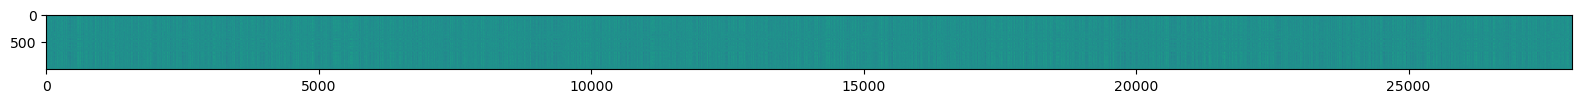

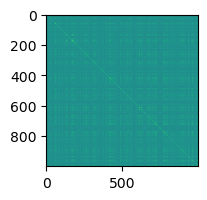

In [11]:
# Plot activity and correlation between classes
N_esn = par.N_esn
a = np.zeros((1000,N_esn*28))
for j in range(len(X_tr)):
    a[j*100:(j+1)*100,:] = X_tr[j][0:100,:].numpy()
c = np.matmul(stats.zscore(a,axis=1), np.transpose(stats.zscore(a,axis=1))) / a.shape[1]
fig = pl.figure(figsize=tuple(np.array((50.,20.))/2.54)); ax = pl.axes()
imdata = ax.imshow(X_tr[0][0:1000,:],vmin=-6.0, vmax=6.0)
fig = pl.figure(figsize=tuple(np.array((50.,20.))/2.54)); ax = pl.axes()
imdata = ax.imshow(X_tr[2][0:1000,:],vmin=-6.0, vmax=6.0)
fig = pl.figure(figsize=tuple(np.array((5.,5.))/2.54)); ax = pl.axes()
imdata = ax.imshow(c,vmin=-1.0, vmax=1.0)
# cb = fig.colorbar(imdata, ticks=[0, 1.0])

In [232]:
X_tr[0].shape

torch.Size([4905, 2800])

In [12]:
class NN(nn.Module):
    
    def __init__(self,Ns,N_class):
        super().__init__()
        
        self.N_class=N_class
        N_layers=np.shape(Ns)[0]
        
        self.Ws=[]
        self.bs=[]
        
        self.Ths=[]
        self.Th_bs=[]
        
        self.Ns=Ns
        for n in range(1,np.shape(Ns)[0]):
        
            self.Ws.append(nn.Parameter(torch.randn([Ns[n-1],Ns[n]])/torch.sqrt(torch.tensor(Ns[n-1]+Ns[n]))))
            self.bs.append(nn.Parameter(torch.zeros([Ns[n]])))
        if Ns[1]==2800:
            self.Ws[0].requires_grad = False
            self.bs[0].requires_grad = False

        
        self.Ths.append( nn.Parameter( torch.randn([Ns[-1],N_class])/torch.sqrt(torch.tensor(Ns[n-1]+Ns[n])) ) ) 
        self.Th_bs.append( nn.Parameter(torch.zeros([N_class])) )
        
    def Initialise_Hyperparameters(self,eta_t, eta_o,batch_size,margin):


        self.eta_t=eta_t
        self.eta_o=eta_o
        self.batch_size=batch_size

        self.opt=optim.Adam([{ 'params': self.Ws+self.bs, 'lr':eta_t }])
        
        self.opt_out=optim.Adam([{ 'params': self.Ths+self.Th_bs, 'lr':eta_o }])
                              
        self.margin=margin
        
        
    def Forward_Triplet(self, S):
        
        ys=[]
        ns = S.shape[1] # Number of samples
        ACC = 0.0
        o = torch.ones(9,1)
        for k in range(3):
        
            xs=[]
            xs.append(S[k,:,:])

            for n in range(0,np.shape(self.Ns)[0]-2):
                # Compute activities in each layer
                xs.append(torch.relu( torch.add(torch.matmul(xs[n],self.Ws[n]),self.bs[n]) ) )

            ys.append( torch.add(torch.matmul(xs[-1],self.Ws[-1]),self.bs[-1]) )
        
        # Use Euclidean distance
        # dneg = torch.sum( torch.pow( ys[0].detach()-ys[2].detach(), 2 ), 1)
        # dposneg = torch.sum( torch.pow( ys[1].detach()-ys[2].detach(), 2 ), 1)
        # # Find the hard negative pairs and swap anchor and positive if dposneg>dneg
        # ind = dneg > dposneg
        # acopy = torch.clone(ys[0])
        # ys[0][ind,:] = torch.clone(ys[1][ind,:])
        # ys[1][ind,:] = torch.clone(acopy[ind,:])
        # # Recompute distances
        dpos = torch.sum( torch.pow( ys[0]-ys[1], 2 ), 1)
        dneg = torch.sum( torch.pow( ys[0]-ys[2], 2 ), 1)
        
        E = dpos - dneg + self.margin
        E = torch.mean( E*(E>0) )
        if E>0:
            
            E.backward()
        
            self.opt.step()
            self.opt.zero_grad()
        
        # # Use correlation
        # a = (ys[0] - torch.matmul(torch.mean(ys[0],1,keepdim=True), torch.ones(1,ys[0].shape[1]))) / torch.matmul(torch.std(ys[0],1,keepdim=True), torch.ones(1,ys[0].shape[1]))
        # p = (ys[1] - torch.matmul(torch.mean(ys[1],1,keepdim=True), torch.ones(1,ys[0].shape[1]))) / torch.matmul(torch.std(ys[1],1,keepdim=True), torch.ones(1,ys[0].shape[1]))
        # n = (ys[2] - torch.matmul(torch.mean(ys[2],1,keepdim=True), torch.ones(1,ys[0].shape[1]))) / torch.matmul(torch.std(ys[2],1,keepdim=True), torch.ones(1,ys[0].shape[1]))
        # dpos = torch.sum( torch.mul(a,p) ,1) / a.shape[1]
        # dneg = torch.sum( torch.mul(a,n) ,1) / a.shape[1]
        # E = torch.mean(dneg - dpos)
        
        # E.backward()
    
        # self.opt.step()
        # self.opt.zero_grad()

        print(f'-----  Triplet loss = {torch.mean(E)},-----  +ve = {torch.mean(dpos)},------  -ve = {torch.mean(dneg)}')
        
        dn = torch.zeros(ns)
        for j in range(ns):            
            ind1 = torch.randperm(ns)
            dn = torch.sum(torch.pow(torch.matmul(o, ys[0][j,None,:]) - ys[2][ind1[0:9],:], 2.), 1)
            ACC += torch.any(dpos[j]*o > dn).logical_not().long()
        ACC /= ns

        return E, ACC, torch.mean(dpos), torch.mean(dneg)
        
        
    def Forward_out(self, S, Y):
       
        
        xs=[]
        xs.append(S)

        for n in range(0,np.shape(self.Ns)[0]-2): # For each layer except the final layer
            # Build up training data so that outputs learn from all previous layers
            xs.append(torch.relu( torch.add(torch.matmul(xs[n],self.Ws[n]),self.bs[n]) ) )

        y= torch.add(torch.matmul(xs[-1],self.Ws[-1]),self.bs[-1])
        out=torch.add(torch.matmul(y.detach(),self.Ths[0]),self.Th_bs[0]) 
        
        E_out=torch.mean(torch.sum( torch.pow( out-Y, 2 ), 1))
        
        Acc=torch.mean(torch.eq( torch.argmax(out,1), torch.argmax(Y,1) ).type(torch.float))
        
        E_out.backward()
        
        self.opt_out.step()
        self.opt_out.zero_grad()
        
        
        return E_out, Acc
        
        
    

In [30]:
# Ns=np.array([X_tr[0].shape[1],200,100]) # normal_MLP
Ns=np.array([X_tr[0].shape[1],100]) # normal_1LP
# Ns=np.array([X_tr[0].shape[1],200,100]) # esn_MLP
# Ns=np.array([X_tr[0].shape[1],100]) # esn_1LP
# Ns=np.array([X_tr[0].shape[1],4000]) # esn_1LP_fanout

N_triplet=50000
N_out=1000
batch_size=64
eta_t=0.0002
eta_o = 0.001
eta_tau = 40000.0
N_class=10
margin=2
save_N = 100 #100 # # of saved epochs
save_every = np.floor(N_triplet / save_N) # Save data every <> epohsChoice 3
save_Nsamples = 100 # # of inputs from each class for which to save resonses
met_save = np.zeros((save_N, Ns[-1], N_class * save_Nsamples))

MLP=NN(Ns,N_class)
MLP.Initialise_Hyperparameters(eta_t,eta_o,batch_size,margin)
DPOS = np.zeros((N_triplet,1))
DNEG = np.zeros((N_triplet,1))
L_tri=np.zeros([N_triplet])
L_out=np.zeros([N_out])
A_tri=np.zeros([N_triplet])
A_out=np.zeros([N_out])

print('**********************START TRIPLET TRAINING')
for n in range(N_triplet):
    
    ### Save met responses before updates
    if n%save_every==(save_every-1):
        with torch.no_grad():
            for j in range(N_class):
                xs=[]
                xs.append(X_tr[j][0:save_Nsamples,:])
                for k in range(0,np.shape(MLP.Ns)[0]-1):
                    xs.append(torch.relu( torch.add(torch.matmul(xs[k],MLP.Ws[k]),MLP.bs[k]) ) )
                met_save[int(np.floor(n/save_every)), :, j*save_Nsamples:(j+1)*save_Nsamples] = torch.transpose(xs[-1],0,1).numpy()
                    # torch.transpose( torch.relu( torch.add(torch.matmul(X_tr[j][0:save_Nsamples,:],MLP.Ws[-1]),MLP.bs[-1]) ), 0, 1).numpy()   
    
    Im=torch.zeros([3,batch_size,Ns[0]])

    for k in range(batch_size):
        
        rand_cl=np.random.permutation(N_class)
        
        #rand_Ps=np.random.permutation(X_tr[rand_cl[0]].size()[0])
        
        # Create 2 random ints from 0 to # of samples in class rand_cl[0]
        rand_Ps=np.random.randint(0,X_tr[rand_cl[0]].size()[0],(2,))
        
        X_a=X_tr[rand_cl[0]][rand_Ps[0],:]
        X_p=X_tr[rand_cl[0]][rand_Ps[1],:]
        
        rand_n=np.random.randint(0,X_tr[rand_cl[1]].size()[0])
        
        X_n=X_tr[rand_cl[1]][rand_n,:]
        
        Im[0,k,:]=torch.clone(X_a)
        Im[1,k,:]=torch.clone(X_p)
        Im[2,k,:]=torch.clone(X_n)
        
    loss, acc, dpos, dneg = MLP.Forward_Triplet(Im)
    
    L_tri[n] = np.copy(np.array(loss.to('cpu').detach()))
    A_tri[n] = np.copy(np.array(acc.to('cpu').detach()))
    DPOS[n] = np.copy(np.array(dpos.to('cpu').detach()))
    DNEG[n] = np.copy(np.array(dneg.to('cpu').detach()))
    
    if (n%100==0) and (n>0):
        
        loss_mean=np.mean(L_tri[n-100:n])
        acc_mean=np.mean(A_tri[n-100:n])
        
        print(f'Mean Triplet Loss: {loss_mean};    Mean accuracy: {acc_mean}')
    
    # Update learning rate
    MLP.opt.param_groups[0]['lr'] = eta_t * np.exp(-float(n)/eta_tau)

print('**********************START OUTPUT TRAINING')

for n in range(N_out):
    
    rand_ind=np.random.randint(0,X_tr[0].size()[0],(int(batch_size/N_class),))
    Im=X_tr[0][rand_ind,:]
    Y=Y_tr[0][rand_ind,:]
    
    for k in range(1,N_class):
        
        rand_ind=np.random.randint(0,X_tr[k].size()[0],(int(batch_size/N_class),))
        Im=torch.concat([Im,X_tr[k][rand_ind,:]],0)
        Y=torch.concat([Y,Y_tr[k][rand_ind,:]],0)
        
    loss,Acc=MLP.Forward_out(Im, Y)
    
    L_out[n]=np.copy(np.array(loss.to('cpu').detach()))
    A_out[n]=np.copy(np.array(Acc.to('cpu').detach()))
    
    if (n%100==0) and (n>0):
        
        mse_mean=np.mean(L_out[n-100:n])
        acc_mean=np.mean(A_out[n-100:n])
        
        print('Mean Error: ', mse_mean, 'Mean Accuracy: ', acc_mean)

### Save outputs
inputDir = './data/'    # Storage directory for input/label data
torch.save(L_tri, inputDir + 'loss_triplet.pt')
torch.save(A_tri, inputDir + 'acc_triplet.pt')
torch.save(np.concatenate((DPOS, DNEG), axis=1), inputDir + 'dist_triplet.pt')
torch.save(L_out, inputDir + 'loss_out.pt')
torch.save(A_out, inputDir + 'acc_out.pt')
torch.save(met_save, inputDir + 'met_save.pt')

    


**********************START TRIPLET TRAINING
-----  Triplet loss = 30.948368072509766,-----  +ve = 191.9233856201172,------  -ve = 206.42605590820312
-----  Triplet loss = 148.94432067871094,-----  +ve = 417.8992919921875,------  -ve = 401.8962707519531
-----  Triplet loss = 39.120689392089844,-----  +ve = 214.78248596191406,------  -ve = 213.58984375
-----  Triplet loss = 73.21549987792969,-----  +ve = 289.6931457519531,------  -ve = 290.1053771972656
-----  Triplet loss = 77.36214447021484,-----  +ve = 323.4492492675781,------  -ve = 309.4897155761719
-----  Triplet loss = 70.04657745361328,-----  +ve = 283.1627197265625,------  -ve = 267.8834533691406
-----  Triplet loss = 40.594337463378906,-----  +ve = 241.41172790527344,------  -ve = 275.7366027832031
-----  Triplet loss = 46.36003875732422,-----  +ve = 250.8555145263672,------  -ve = 254.2939910888672
-----  Triplet loss = 40.58212661743164,-----  +ve = 257.170654296875,------  -ve = 295.5445251464844
-----  Triplet loss = 40.42

KeyboardInterrupt: 

# Plot data

In [31]:
### Load data
inputDir = './data/'    # Storage directory for input/label data
met = torch.load(inputDir + 'met_save.pt')
l_tri = torch.load(inputDir + 'loss_triplet.pt')
l_out = torch.load(inputDir + 'loss_out.pt')
a_tri = torch.load(inputDir + 'acc_triplet.pt')
a_out = torch.load(inputDir + 'acc_out.pt')
dist = torch.load(inputDir + 'dist_triplet.pt')
nt_dist = dist.shape[0] 
nt_out = l_out.shape[0]
nt_met = met.shape[0]
print(l_out.shape)

(1000,)


### Plot triplet distances and loss

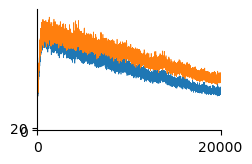

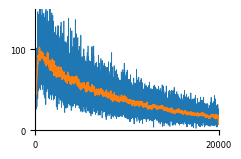

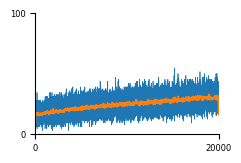

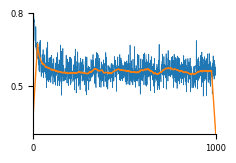

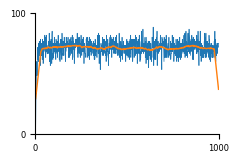

In [32]:
from matplotlib import pyplot as pl
# saveflag = True
saveflag = False

kernel = np.ones(50)/50
prefix = 'esn1000_contrast'
mpl.rcParams['savefig.dpi'] = 300
mpl.rcParams['axes.labelsize'] = 6
mpl.rcParams['svg.fonttype'] = 'none'
mpl.rcParams['savefig.format'] = 'svg'

###Plot distances
fig = pl.figure(figsize=tuple(np.array((6.,4.))/2.54)); ax = pl.axes()
ax.spines[['top','right']].set_visible(False)
# pl.plot(np.log10(np.linspace(1,nt_dist,nt_dist)),dist[:,0]); pl.plot(np.log10(np.linspace(1,nt_dist,nt_dist)),dist[:,1], linestyle='dashed')
pl.plot(np.linspace(1,nt_dist,nt_dist),dist[:,0], linewidth=0.5); pl.plot(np.linspace(1,nt_dist,nt_dist),dist[:,1], linewidth=0.5)
ax.set_xlim(xmin=0, xmax=np.log10(nt_dist)); ax.set_ylim(ymin=0.0, ymax=1000)
# ax.xaxis.set_ticks((np.log10((1,10,100,1000,10000)))); ax.yaxis.set_ticks((0,15,30))
ax.xaxis.set_ticks((0,nt_dist)); ax.yaxis.set_ticks((0,20))
# ax.tick_params(axis='both', which='major', labelsize=6.0)
if saveflag:
    pl.savefig('/home/jb739/sheffield/proj/esn2sparse/data/'+prefix+'distances.svg', format="svg")

###Plot triplett loss
fig = pl.figure(figsize=tuple(np.array((6.,4.))/2.54)); ax = pl.axes()
ax.spines[['top','right']].set_visible(False)
# pl.plot(np.log10(np.linspace(1,nt_dist,nt_dist)),l_tri); pl.plot(np.log10(np.linspace(1,nt_dist,nt_distX_tr.shape)),np.convolve(l_tri,kernel,mode='same')); 
pl.plot(np.linspace(1,nt_dist,nt_dist),l_tri, linewidth=0.5); pl.plot(np.linspace(1,nt_dist,nt_dist),np.convolve(l_tri,kernel,mode='same'), linewidth=1.0); 
# ax.set_xlim(xmin=0, xmax=np.log10(nt_dist)); ax.set_ylim(ymin=0.0, ymax=0.5*1.05*np.max(l_tri))
ax.set_xlim(xmin=0, xmax=np.log10(nt_dist)); ax.set_ylim(ymin=0.0, ymax=150.0)
# ax.xaxis.set_ticks((np.log10((1,10,100,1000,10000)))); ax.yaxis.set_ticks((0,5))
ax.xaxis.set_ticks((0,nt_dist)); ax.yaxis.set_ticks((0,100))
ax.tick_params(axis='both', which='major', labelsize=6.0)
if saveflag:
    pl.savefig('/home/jb739/sheffield/proj/esn2sparse/data/'+prefix+'loss_triplet.eps', format="eps")

###Plot triplet accuracy
fig = pl.figure(figsize=tuple(np.array((6.,4.))/2.54)); ax = pl.axes()
ax.spines[['top','right']].set_visible(False)
pl.plot(np.linspace(1,nt_dist,nt_dist),a_tri*100, linewidth=0.5); pl.plot(np.linspace(1,nt_dist,nt_dist),np.convolve(a_tri*100,kernel,mode='same'), linewidth=1.0); 
ax.set_xlim(xmin=0, xmax=np.log10(nt_dist)); ax.set_ylim(ymin=0.0, ymax=100.)
# ax.xaxis.set_ticks((np.log10((1,10,100,1000,10000)))); ax.yaxis.set_ticks((0,5))
ax.xaxis.set_ticks((0,nt_dist)); ax.yaxis.set_ticks((0,100))
ax.tick_params(axis='both', which='major', labelsize=6.0)
if saveflag:
    pl.savefig('/home/jb739/sheffield/proj/esn2sparse/data/'+prefix+'acc_triplet.eps', format="eps")

###Plot output loss
fig = pl.figure(figsize=tuple(np.array((6.,4.))/2.54)); ax = pl.axes()
ax.spines[['top','right']].set_visible(False)
# pl.plot(np.log10(np.linspace(1,nt_dist,nt_dist)),l_tri); pl.plot(np.log10(np.linspace(1,nt_dist,nt_dist)),np.convolve(l_tri,kernel,mode='same')); 
pl.plot(np.linspace(1,nt_out,nt_out),l_out, linewidth=0.5); pl.plot(np.linspace(1,nt_out,nt_out),np.convolve(l_out,kernel,mode='same'), linewidth=1.0); 
ax.set_xlim(xmin=0, xmax=np.log10(nt_dist)); ax.set_ylim(ymin=0.3, ymax=0.8)
# ax.xaxis.set_ticks((np.log10((1,10,100,1000,10000)))); ax.yaxis.set_ticks((0,5))
ax.xaxis.set_ticks((0,nt_out)); ax.yaxis.set_ticks((0.5,0.8))
ax.tick_params(axis='both', which='major', labelsize=6.0)
if saveflag:
    pl.savefig('/home/jb739/sheffield/proj/esn2sparse/data/'+prefix+'loss_out.eps', format="eps")

###Plot output accuracy
fig = pl.figure(figsize=tuple(np.array((6.,4.))/2.54)); ax = pl.axes()
ax.spines[['top','right']].set_visible(False)
pl.plot(np.linspace(1,nt_out,nt_out),a_out*100, linewidth=0.5); pl.plot(np.linspace(1,nt_out,nt_out),np.convolve(a_out*100,kernel,mode='same'), linewidth=1.0); 
ax.set_xlim(xmin=0, xmax=np.log10(nt_out)); ax.set_ylim(ymin=0.0, ymax=100.)
# ax.xaxis.set_ticks((np.log10((1,10,100,1000,10000)))); ax.yaxis.set_ticks((0,5))
ax.xaxis.set_ticks((0,nt_out)); ax.yaxis.set_ticks((0,100))
ax.tick_params(axis='both', which='major', labelsize=6.0)
if saveflag:
    pl.savefig('/home/jb739/sheffield/proj/esn2sparse/data/'+prefix+'acc_out.eps', format="eps")

### Plot met responses over training

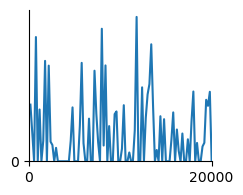

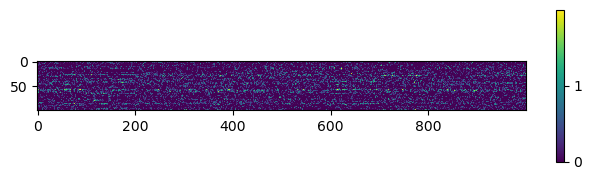

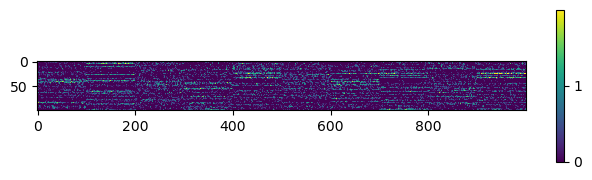

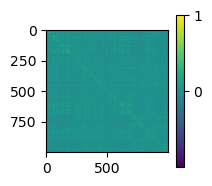

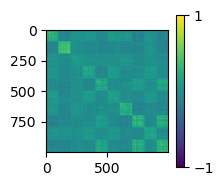

In [29]:
from matplotlib import pyplot as pl
from scipy import stats
pl.rcParams['savefig.dpi'] = 300

# saveflag = True
saveflag = False

### Raw met reponses
fig = pl.figure(figsize=tuple(np.array((6.,5.))/2.54)); ax = pl.axes()
ax.spines[['top','right']].set_visible(False)
plmet = np.squeeze(met[0,:,199])
pl.plot(np.linspace(1,nt_met,nt_met)*save_every,plmet)
ax.set_xlim(xmin=0, xmax=nt_met*save_every); ax.set_ylim(ymin=0.0, ymax=1.05*np.max(plmet))
ax.xaxis.set_ticks((0,nt_met*save_every)); ax.yaxis.set_ticks((0,))
pl.show()

fig = pl.figure(figsize=tuple(np.array((20.,5.))/2.54)); ax = pl.axes()
c0 = stats.zscore(np.squeeze(met[0,:,:]),0)
imdata = ax.imshow(c0,vmin=0.0, vmax=2.0)
cb = fig.colorbar(imdata, ticks=[0, 1.0])
if saveflag:
    pl.savefig('/home/jb739/sheffield/proj/esn2sparse/data/'+prefix+'met0.eps', format="eps")
fig = pl.figure(figsize=tuple(np.array((20.,5.))/2.54)); ax = pl.axes()
c0 = stats.zscore(np.squeeze(met[-1,:,:]),0)
imdata = ax.imshow(c0,vmin=0.0, vmax=2.0)
cb = fig.colorbar(imdata, ticks=[0, 1.0])
if saveflag:
    pl.savefig('/home/jb739/sheffield/proj/esn2sparse/data/'+prefix+'met1.eps', format="eps")

### Correlation between met responses
fig = pl.figure(figsize=tuple(np.array((5.,5.))/2.54)); ax = pl.axes()
c0 = np.matmul(stats.zscore(np.squeeze(met[0,:,:]),0).transpose(), stats.zscore(np.squeeze(met[0,:,:]),0)) / met.shape[1]
imdata = ax.imshow(c0,vmin=-1.0, vmax=1.0)
cb = fig.colorbar(imdata, ticks=[0, 1.0])
if saveflag:
    pl.savefig('/home/jb739/sheffield/proj/esn2sparse/data/'+prefix+'met0_corr.eps', format="eps")
fig = pl.figure(figsize=tuple(np.array((5.,5.))/2.54)); ax = pl.axes()
c1 = np.matmul(stats.zscore(np.squeeze(met[-1,:,:]),0).transpose(), stats.zscore(np.squeeze(met[-1,:,:]),0)) / met.shape[1]
imdata = ax.imshow(c1,vmin=-1.0, vmax=1.0)
cb = fig.colorbar(imdata, ticks=[-1.0, 1.0])
if saveflag:
    pl.savefig('/home/jb739/sheffield/proj/esn2sparse/data/'+prefix+'met1_corr.eps', format="eps")


# Plot weights

In [17]:
w = torch.load('/home/jb739/sheffield/proj/esn2sparse/data/wsav.pt')
w.shape

NameError: name 'ys' is not defined